# 6.6 Sourcing & Analyzing Time Series Data


## Contents list:

#### 01 Importing libraries
#### 02 Importing data
#### 03 Subsetting, wrangling, and cleaning time series data
#### 04 Time series analysis: decomposition
#### 05 Testing for stationarity
#### 06 Stationarizing data

#### 01 Importing libraries

In [1]:
# Import libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
import statsmodels.api as sm # Using .api imports the public access version of statsmodels, which is a library that handles 
# statistical models.
import os
import warnings 
warnings.filterwarnings("ignore")
plt.style.use('fivethirtyeight') 

#### 02 Importing data

In [2]:
# Project folder path as string
path = r'C:\Users\User\Desktop\Chocolate Bar Ratings'

In [3]:
# Import exploring_relationships.csv data set using the os library
df_c= pd.read_csv(os.path.join(path, '02 Data', 'Prepared Data', 'exploring_relationships.csv'), index_col = False)

#### 03 Subsetting, wrangling, and cleaning time series data

In [4]:
# Check the shape
df_c.shape

(1721, 10)

In [5]:
# Check the column names
df_c.columns

Index(['Unnamed: 0', 'company', 'specific_bean_origin_or_bar_name',
       'reference_number', 'review_date', 'cocoa_percent', 'company_location',
       'rating', 'broad_bean_origin', 'cocoa_percent_category'],
      dtype='object')

In [6]:
# Create a data frame with variables review_date and rating 
df_1 = df_c[['review_date','rating']]

In [7]:
# Check the column names
df_1.columns

Index(['review_date', 'rating'], dtype='object')

In [8]:
# Creating a new dataframe by grouping data
df = df_1.groupby('review_date')['rating'].min().reset_index()
df['m_rating'] = df['rating']
df.drop(columns = ['rating'], inplace=True)
df.head()

,review_date,m_rating
0,2006,2.00
1,2007,1.00
2,2008,1.00
3,2009,1.50
4,2010,1.75


In [9]:
# Set the review_date as the index of the dataframe 
df=df.set_index('review_date')
df.index = pd.to_datetime(df.index, format='%Y')
df.head()

,m_rating
review_date,
2006-01-01,2.00
2007-01-01,1.00
2008-01-01,1.00
2009-01-01,1.50
2010-01-01,1.75


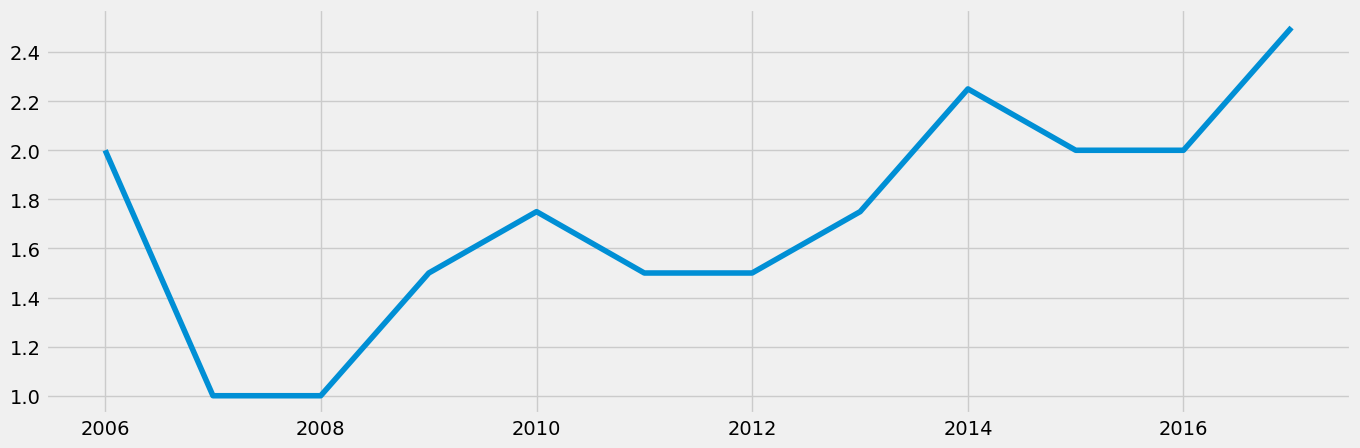

In [10]:
# Create a line chart of df
plt.figure(figsize=(15,5), dpi=100)
plt.plot(df)

In [11]:
# Check for missing values
df.isnull().sum()

m_rating    0
dtype: int64

In [12]:
# Check for duplicates
dups = df.duplicated()
dups.sum() # The rating ranges from 1 to 5, so it is possible to have the same rating in different years.

6

#### 04 Time series analysis: decomposition

In [13]:
# Decompose the time series using an additive model

decomposition = sm.tsa.seasonal_decompose(df, model='additive')

In [14]:
# Define a fixed size for all special charts
from pylab import rcParams 

rcParams['figure.figsize'] = 18, 7

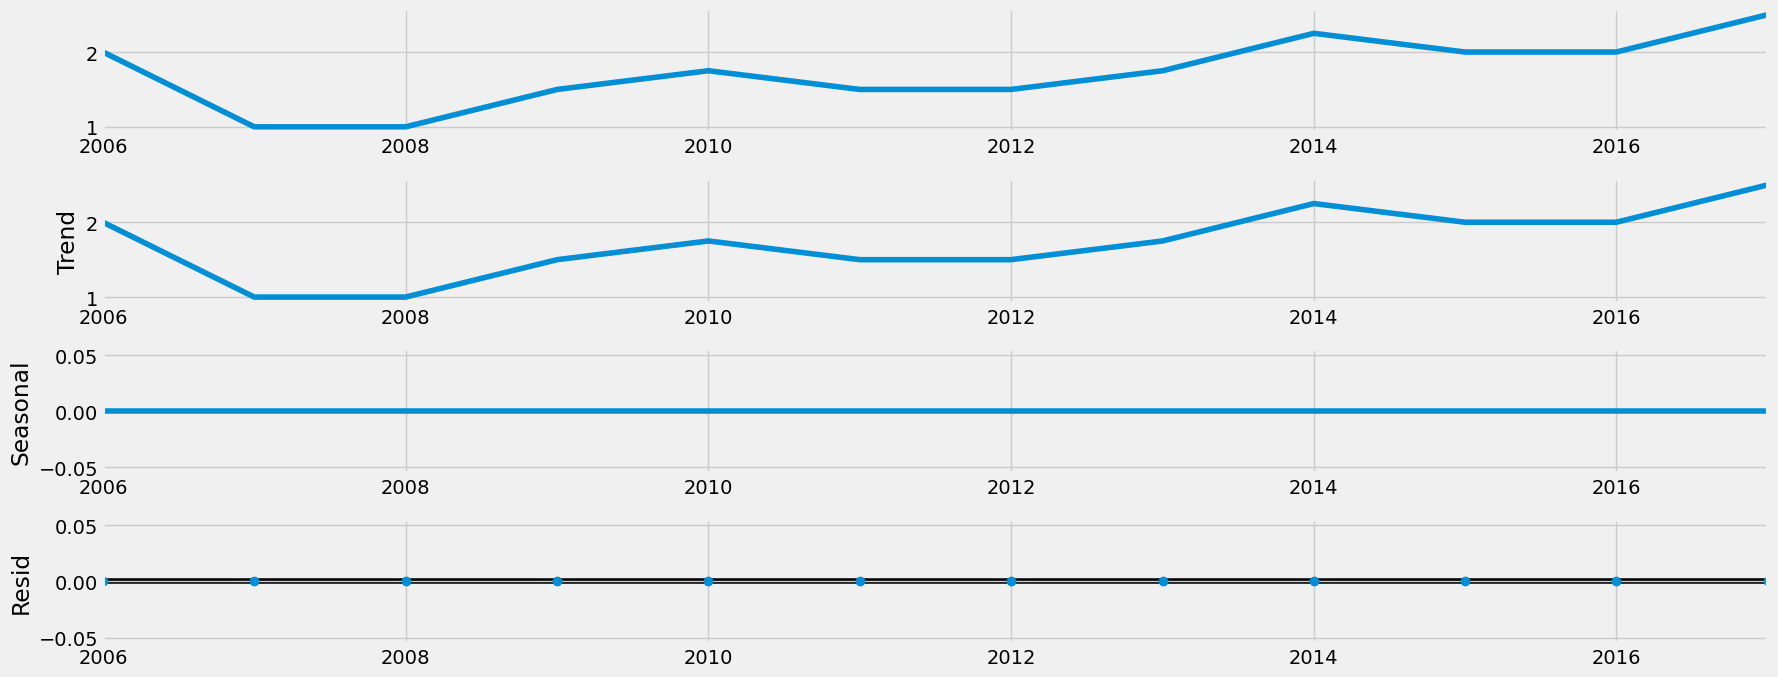

In [15]:
# Plot the separate components

decomposition.plot()
plt.show()

- Observing the chart, it is visible that the level and trend (first two lines) are the same, which could mean that the data does not have a lot of noise, so the data does not need to be smoothed, which is confirmed by the last line - the residual. The seasonal line is flat, which indicates that there is no presence of seasonality.


#### 05 Testing for stationarity

In [16]:
# Import the adfuller() function
from statsmodels.tsa.stattools import adfuller 
# Define the function
def dickey_fuller(timeseries): 
    # Perform the Dickey-Fuller test:
    print ('Dickey-Fuller Stationarity test:')
    test = adfuller(timeseries, autolag='AIC')
    result = pd.Series(test[0:4], index=['Test Statistic','p-value','Number of Lags Used','Number of Observations Used'])
    for key,value in test[4].items():
       result['Critical Value (%s)'%key] = value
    print (result)
# Apply the test using the function on the time series
dickey_fuller(df['m_rating'])

Dickey-Fuller Stationarity test:
Test Statistic                 1.101064
p-value                        0.995226
Number of Lags Used            4.000000
Number of Observations Used    7.000000
Critical Value (1%)           -4.938690
Critical Value (5%)           -3.477583
Critical Value (10%)          -2.843868
dtype: float64


- The test showed the following results: p value > 0.05, and the test statistic value is greater than all critical values of the corresponding significance level( 1%, 5%, and 10%).This means that the null hypothesis cannot be rejected and that there is a presence of a unit root.

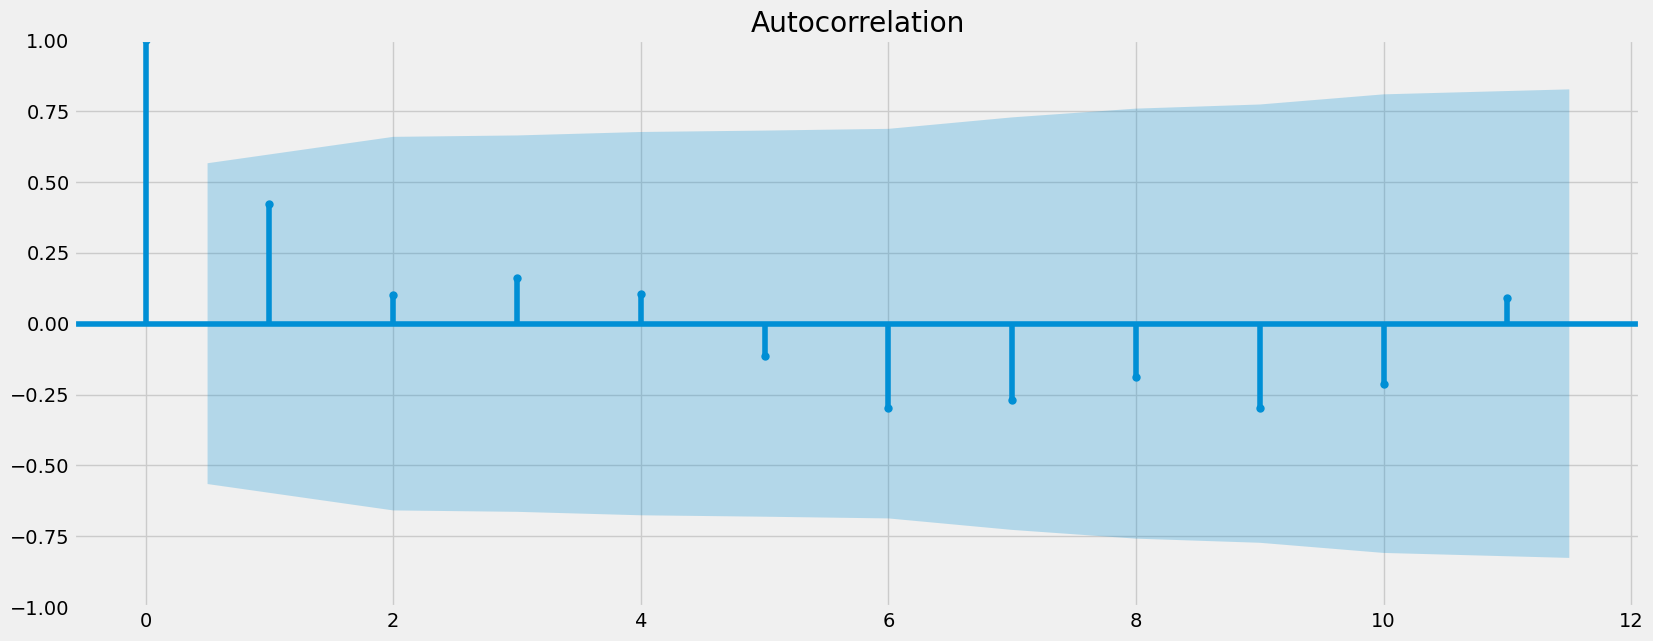

In [17]:
# Check autocorrelations
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf 
plot_acf(df)
plt.show()

In [18]:
# The df.shift(1) function 
data_diff = df - df.shift(1) 

In [19]:
# Remove the missing values that came about as a result of the differencing
data_diff.dropna(inplace = True) 

In [20]:
data_diff.head()

,m_rating
review_date,
2007-01-01,-1.00
2008-01-01,0.00
2009-01-01,0.50
2010-01-01,0.25
2011-01-01,-0.25


In [21]:
data_diff.columns

Index(['m_rating'], dtype='object')

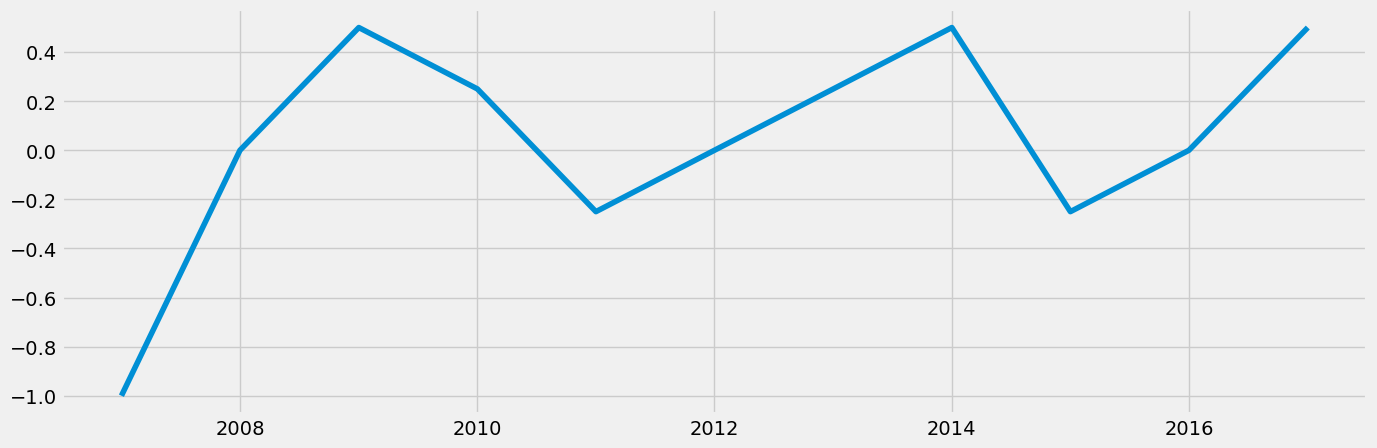

In [22]:
# Check the time-series curve after the differencing 

plt.figure(figsize=(15,5), dpi=100)
plt.plot(data_diff)

In [23]:
# Apply the test using the function on the time series
dickey_fuller(data_diff)

Dickey-Fuller Stationarity test:
Test Statistic                -4.267123
p-value                        0.000506
Number of Lags Used            2.000000
Number of Observations Used    8.000000
Critical Value (1%)           -4.665186
Critical Value (5%)           -3.367187
Critical Value (10%)          -2.802961
dtype: float64


- After differentiation, the test showed the following results: p value < 0.05, and the test statistic value is smaller than critical values corresponding significance level (1% and 5%). This means that the null hypothesis can be rejected.

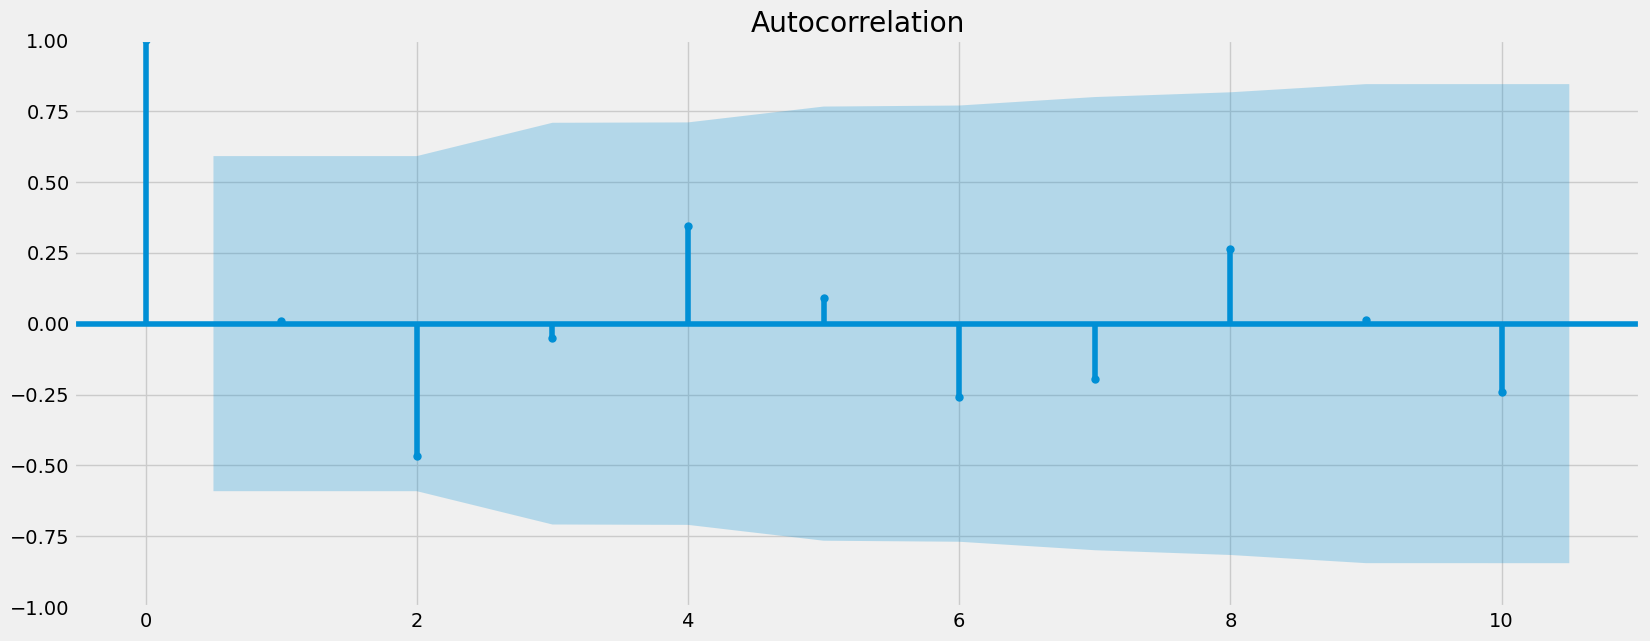

In [24]:
# Re-check autocorrelations

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

plot_acf(data_diff)
plt.show()

- The vertical lines-series lags are within the confidence interval, which means that they are not statistically significantly correlated with each other, and that the data are stationary.